운동 동작 분류 AI 경진대회에서 CNN-1D를 Keras를 활용하여 구축하여 2위를 달성하신 분의 모델을 Pytorch로 구현했습니다.

https://dacon.io/competitions/official/235689/codeshare/2396?page=2&dtype=recent

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

input_layer = keras.layers.Input((600,18))
conv1 = keras.layers.Conv1D(filters=128, kernel_size=9, padding='same')(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)
conv1 = keras.layers.Dropout(rate=0.3)(conv1)

conv2 = keras.layers.Conv1D(filters=256, kernel_size=6, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)
conv2 = keras.layers.Dropout(rate=0.4)(conv2)

conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)
conv3 = keras.layers.Dropout(rate=0.5)(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(61, activation='softmax')(gap)

model = keras.models.Model(inputs = input_layer, outputs = output_layer)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), 
    metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 18)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 600, 128)          20864     
_________________________________________________________________
batch_normalization_3 (Batch (None, 600, 128)          512       
_________________________________________________________________
activation_3 (Activation)    (None, 600, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 600, 256)          196864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 600, 256)          1024

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib as mpl
import seaborn as sns
import warnings

from tqdm import tqdm
from numpy.fft import fft, fftshift
from scipy import signal

warnings.filterwarnings(action='ignore')
%matplotlib inline

# 데이터 불러오기

In [ ]:
paths = '/content/drive/MyDrive/DataAnalysis/운동 동작 분류 AI 경진대회/data/'

train = pd.read_csv(paths + 'train_features.csv')
train_labels = pd.read_csv(paths + 'train_labels.csv')
test = pd.read_csv(paths + 'test_features.csv')
submission = pd.read_csv(paths + 'sample_submission.csv')

# 재현가능성을 위한 시드 고정

In [ ]:
# 구글 코랩을 통해서 GPU를 이용한 학습을 함

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [ ]:
# 재현가능성을 위한 seed 고정
def seed_everything(seed = 22):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

  # torch 용
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything()

# 데이터 전처리

In [ ]:
## Energy
train['acc_Energy']=(train['acc_x']**2+train['acc_y']**2+train['acc_z']**2)**(1/3)
test['acc_Energy']=(test['acc_x']**2+test['acc_y']**2+test['acc_z']**2)**(1/3)

train['gy_Energy']=(train['gy_x']**2+train['gy_y']**2+train['gy_z']**2)**(1/3)
test['gy_Energy']=(test['gy_x']**2+test['gy_y']**2+test['gy_z']**2)**(1/3)

train['gy_acc_Energy']=((train['gy_x']-train['acc_x'])**2+(train['gy_y']-train['acc_y'])**2+(train['gy_z']-train['acc_z'])**2)**(1/3)
test['gy_acc_Energy']=((test['gy_x']-test['acc_x'])**2+(test['gy_y']-test['acc_y'])**2+(test['gy_z']-test['acc_z'])**2)**(1/3)

In [ ]:
dt=0.02 
def jerk_signal(signal): 
  return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])

In [ ]:
train_dt=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for v in train.columns[2:]:
        values=jerk_signal(temp[v].values)
        values=np.insert(values,0,0)
        temp.loc[:,v+'_dt']=values
    train_dt.append(temp)

100%|██████████| 3125/3125 [00:44<00:00, 69.75it/s]


In [ ]:
test_dt=[]
for i in tqdm(test['id'].unique()):
    temp=test.loc[test['id']==i]
    for v in train.columns[2:]:
        values=jerk_signal(temp[v].values)
        values=np.insert(values,0,0)
        temp.loc[:,v+'_dt']=values
    test_dt.append(temp)

100%|██████████| 782/782 [00:10<00:00, 76.66it/s]


In [ ]:
from scipy import fftpack
from numpy.fft import *

def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

In [ ]:
train=pd.concat(train_dt)

In [ ]:
fft=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for i in train.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft.append(temp)
train=pd.concat(fft)

100%|██████████| 3125/3125 [00:10<00:00, 287.83it/s]


In [ ]:
test=pd.concat(test_dt)

In [ ]:
fft_t=[]
for i in tqdm(test['id'].unique()):
    temp=test.loc[test['id']==i]
    for i in test.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft_t.append(temp)
test=pd.concat(fft_t)

100%|██████████| 782/782 [00:01<00:00, 432.01it/s]


In [ ]:
col=train.columns
train_s=train.copy()
test_s=test.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()

train_s.iloc[:,2:]= scaler.fit_transform(train_s.iloc[:,2:])
train_sc = pd.DataFrame(data = train_s,columns =col)

test_s.iloc[:,2:]= scaler.transform(test_s.iloc[:,2:])
test_sc = pd.DataFrame(data = test_s,columns =col)

In [ ]:
train_sc.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.495681,-0.272719,-0.276391,0.000027,0.000298,-0.000433,0.000347,0.000373,0.000273,0.000101,0.001505,0.001501
1,0,1,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.742974,-0.236152,-0.240632,0.416836,-0.118821,-0.255054,0.032738,-0.349095,0.377085,0.564992,0.166566,0.162871
2,0,2,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.819822,-0.169815,-0.173080,0.086405,0.023750,-0.531727,-0.141582,-0.202368,-0.004887,0.175645,0.300944,0.306341
3,0,3,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.785669,-0.035229,-0.040560,-0.058780,-0.213920,0.285459,0.229520,-0.385106,-0.135647,-0.077915,0.609008,0.599518
4,0,4,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.791528,0.021954,0.016872,0.039823,0.259227,-0.055206,0.057320,-0.174917,-0.028047,0.013483,0.259626,0.260669


In [ ]:
X = np.swapaxes(np.array(train_sc.iloc[:,2:]).reshape(-1, 600, 18), 1, 2)

# new = []
# for i in X:
#   new.append(i.T.reshape(-1, 18, 600))
# X = np.concatenate(new)

X.shape

(3125, 18, 600)

In [ ]:
test_X = np.swapaxes(np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1), 1, 2)

# new = []
# for i in test_X:
#   new.append(i.T.reshape(-1, 18, 600))
# test_X = np.concatenate(new)

test_X.shape

(782, 18, 600)

In [ ]:
y = train_labels['label'].values
y.shape

(3125,)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
num_classes = len(np.unique(y))

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data.reshape(-1,1)[idx])[0]
      return x, y

In [ ]:
dataset = CustomDataset(x_data = X, y_data = y)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

for (X_train, y_train) in dataloader:
  print(X_train.size())
  print(y_train.size())
  break

torch.Size([64, 18, 600])
torch.Size([64])


# 모델 구현

keras와 pytorch의 BatchNorm이 다른 이유

https://stackoverflow.com/questions/60079783/difference-between-keras-batchnormalization-and-pytorchs-batchnorm2d

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes = 61):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv1d(in_channels = 18, out_channels = 128, kernel_size = 9, padding= 4, stride = 1),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Dropout(0.3)
    )
    
    # 커널사이즈를 비대칭으로 만들어 6과 동일한 특징을 가지게 만든다.
    self.conv2 = nn.Sequential(
      nn.Conv1d(in_channels = 128 , out_channels = 256, kernel_size = 6, padding= 0, stride = 1),
      nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Dropout(0.4)
    )

    self.conv3 = nn.Sequential(
      nn.Conv1d(in_channels = 256 , out_channels = 128, kernel_size = 3, padding= 1, stride = 1),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Dropout(0.5)
    )
    self.FC = nn.Linear(128, num_classes)

  def forward(self, x):
    out = self.conv1(x)
    # 비대칭 패널 만들기
    # https://hichoe95.tistory.com/116
    p1d = (3, 2)
    out = F.pad(out, p1d, "constant", 0)
    out = self.conv2(out)
    out = self.conv3(out)
    out = F.avg_pool1d(out, 600)
    out = out.view(out.size(0), -1)
    out = self.FC(out)

    return out

In [ ]:
from torchsummary import summary

model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, eps = 1e-06, patience = 4)
criterion = nn.CrossEntropyLoss()

summary(CNN().to(DEVICE), (18, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 600]          20,864
       BatchNorm1d-2             [-1, 128, 600]             256
              ReLU-3             [-1, 128, 600]               0
           Dropout-4             [-1, 128, 600]               0
            Conv1d-5             [-1, 256, 600]         196,864
       BatchNorm1d-6             [-1, 256, 600]             512
              ReLU-7             [-1, 256, 600]               0
           Dropout-8             [-1, 256, 600]               0
            Conv1d-9             [-1, 128, 600]          98,432
      BatchNorm1d-10             [-1, 128, 600]             256
             ReLU-11             [-1, 128, 600]               0
          Dropout-12             [-1, 128, 600]               0
           Linear-13                   [-1, 61]           7,869
Total params: 325,053
Trainable params:

# 훈련 함수

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  train_loss = 0
  correct = 0

  for batch_idx, (feature, label) in enumerate(train_loader):
    feature = feature.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(feature)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
        epoch, batch_idx * len(feature), 
        len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
        loss.item()))
      
  train_loss /= len(train_loader.dataset)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

# 평가 함수

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for feature, label in test_loader:
      feature = feature.to(DEVICE)
      label = label.to(DEVICE)
      output = model(feature)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

# 학습

---------------------------------1번째 oof 시작-------------------------------
Train Epoch: 1 [0/2812 (0%)]	Train Loss: 4.146671

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0432, 	Train Accuracy: 47.83 %, 	Val Loss: 0.0373, 	Val Accuracy: 52.08 % 

Train Epoch: 2 [0/2812 (0%)]	Train Loss: 2.054962

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0317, 	Train Accuracy: 52.42 %, 	Val Loss: 0.0327, 	Val Accuracy: 53.67 % 

Train Epoch: 3 [0/2812 (0%)]	Train Loss: 1.518603

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0273, 	Train Accuracy: 54.94 %, 	Val Loss: 0.0311, 	Val Accuracy: 56.23 % 

Train Epoch: 4 [0/2812 (0%)]	Train Loss: 1.598723

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0248, 	Train Accuracy: 56.29 %, 	Val Loss: 0.0231, 	Val Accuracy: 62.62 % 

Train Epoch: 5 [0/2812 (0%)]	Train Loss: 1.668726

[EPOCH: 5], Lr: {0.1}	Train Loss: 0.0221, 	Train Accuracy: 59.71 %, 	Val Loss: 0.0225, 	Val Accuracy: 59.42 % 

Train Epoch: 6 [0/2812 (0%)]	Train Loss: 1.413494

[EPOCH: 6], Lr: {0.1}	Train Loss: 0.0204, 	Train Accuracy: 

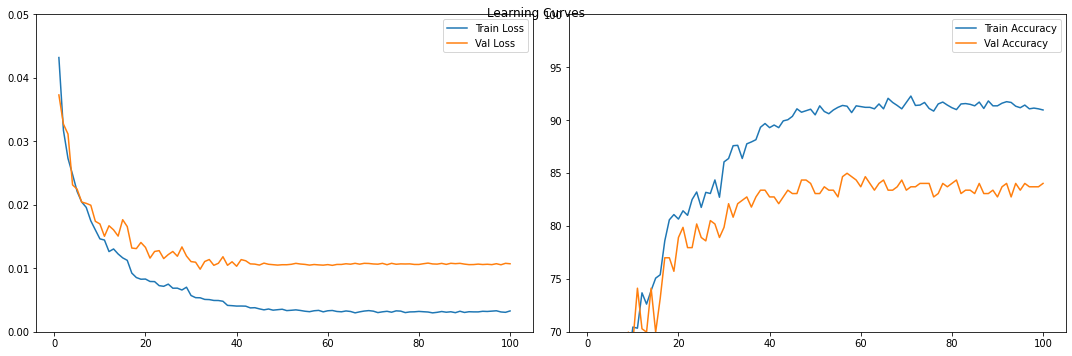

--------------------Best Model-------------------
Best Val Epoch:      57
Best Train Loss:     0.0033
Best Train Accuracy: 91.3229
Best Val Loss:       0.0106
Best Val Accuracy:   84.9840
---------------------------------1번째 oof 종료-------------------------------
---------------------------------2번째 oof 시작-------------------------------
Train Epoch: 1 [0/2812 (0%)]	Train Loss: 4.160616

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0416, 	Train Accuracy: 47.33 %, 	Val Loss: 0.0352, 	Val Accuracy: 53.35 % 

Train Epoch: 2 [0/2812 (0%)]	Train Loss: 2.059135

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0304, 	Train Accuracy: 51.60 %, 	Val Loss: 0.0282, 	Val Accuracy: 55.91 % 

Train Epoch: 3 [0/2812 (0%)]	Train Loss: 1.607596

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0262, 	Train Accuracy: 54.16 %, 	Val Loss: 0.0274, 	Val Accuracy: 58.79 % 

Train Epoch: 4 [0/2812 (0%)]	Train Loss: 1.819880

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0227, 	Train Accuracy: 57.29 %, 	Val Loss: 0.0211, 	Val Accuracy: 63.26 % 

Train Epoc

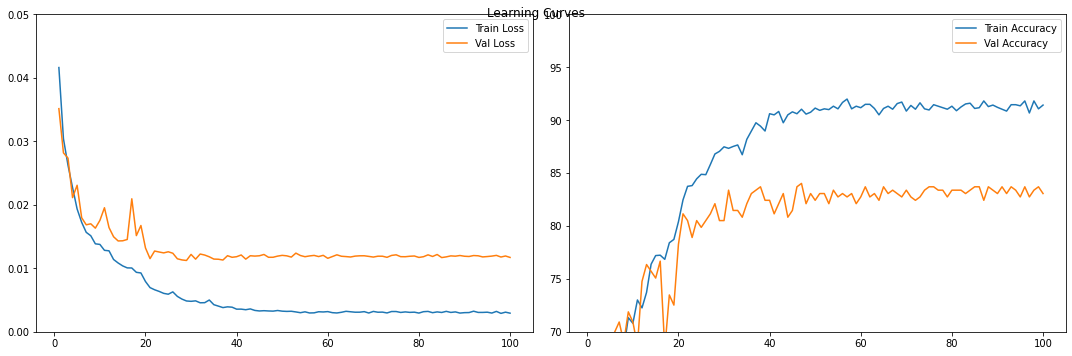

--------------------Best Model-------------------
Best Val Epoch:      47
Best Train Loss:     0.0033
Best Train Accuracy: 91.0384
Best Val Loss:       0.0117
Best Val Accuracy:   84.0256
---------------------------------2번째 oof 종료-------------------------------
---------------------------------3번째 oof 시작-------------------------------
Train Epoch: 1 [0/2812 (0%)]	Train Loss: 4.136215

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0422, 	Train Accuracy: 47.90 %, 	Val Loss: 0.0349, 	Val Accuracy: 51.76 % 

Train Epoch: 2 [0/2812 (0%)]	Train Loss: 2.235594

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0318, 	Train Accuracy: 50.78 %, 	Val Loss: 0.0306, 	Val Accuracy: 52.72 % 

Train Epoch: 3 [0/2812 (0%)]	Train Loss: 1.846725

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0275, 	Train Accuracy: 52.99 %, 	Val Loss: 0.0271, 	Val Accuracy: 55.91 % 

Train Epoch: 4 [0/2812 (0%)]	Train Loss: 1.409577

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0252, 	Train Accuracy: 55.48 %, 	Val Loss: 0.0269, 	Val Accuracy: 55.27 % 

Train Epoc

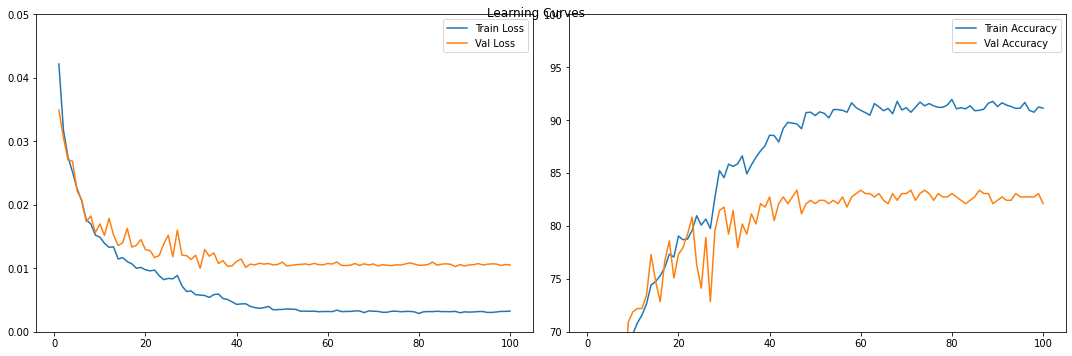

--------------------Best Model-------------------
Best Val Epoch:      86
Best Train Loss:     0.0032
Best Train Accuracy: 90.9317
Best Val Loss:       0.0107
Best Val Accuracy:   83.3866
---------------------------------3번째 oof 종료-------------------------------
---------------------------------4번째 oof 시작-------------------------------
Train Epoch: 1 [0/2812 (0%)]	Train Loss: 4.164790

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0421, 	Train Accuracy: 47.90 %, 	Val Loss: 0.0386, 	Val Accuracy: 49.52 % 

Train Epoch: 2 [0/2812 (0%)]	Train Loss: 2.132980

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0310, 	Train Accuracy: 51.39 %, 	Val Loss: 0.0310, 	Val Accuracy: 54.95 % 

Train Epoch: 3 [0/2812 (0%)]	Train Loss: 1.769603

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0270, 	Train Accuracy: 53.81 %, 	Val Loss: 0.0264, 	Val Accuracy: 56.55 % 

Train Epoch: 4 [0/2812 (0%)]	Train Loss: 1.705163

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0234, 	Train Accuracy: 57.50 %, 	Val Loss: 0.0218, 	Val Accuracy: 63.26 % 

Train Epoc

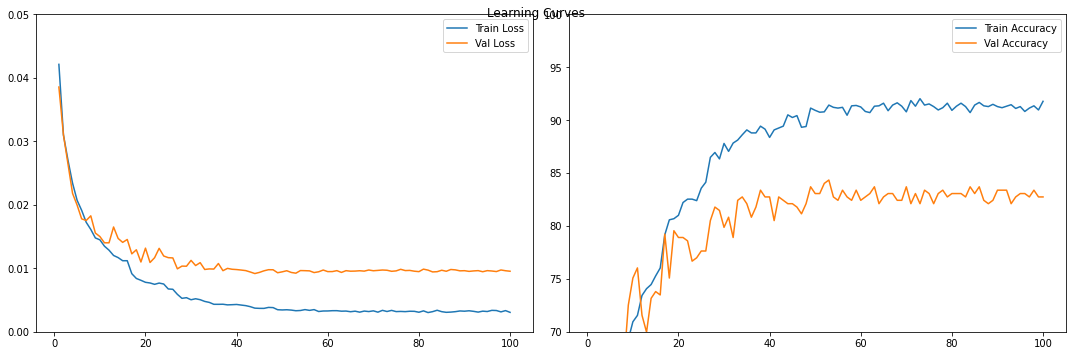

--------------------Best Model-------------------
Best Val Epoch:      53
Best Train Loss:     0.0033
Best Train Accuracy: 91.4296
Best Val Loss:       0.0092
Best Val Accuracy:   84.3450
---------------------------------4번째 oof 종료-------------------------------
---------------------------------5번째 oof 시작-------------------------------
Train Epoch: 1 [0/2812 (0%)]	Train Loss: 4.112517

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0416, 	Train Accuracy: 47.69 %, 	Val Loss: 0.0361, 	Val Accuracy: 50.80 % 

Train Epoch: 2 [0/2812 (0%)]	Train Loss: 2.420323

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0304, 	Train Accuracy: 51.35 %, 	Val Loss: 0.0304, 	Val Accuracy: 54.31 % 

Train Epoch: 3 [0/2812 (0%)]	Train Loss: 1.983701

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0257, 	Train Accuracy: 55.12 %, 	Val Loss: 0.0271, 	Val Accuracy: 59.42 % 

Train Epoch: 4 [0/2812 (0%)]	Train Loss: 1.592752

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0222, 	Train Accuracy: 59.89 %, 	Val Loss: 0.0239, 	Val Accuracy: 61.02 % 

Train Epoc

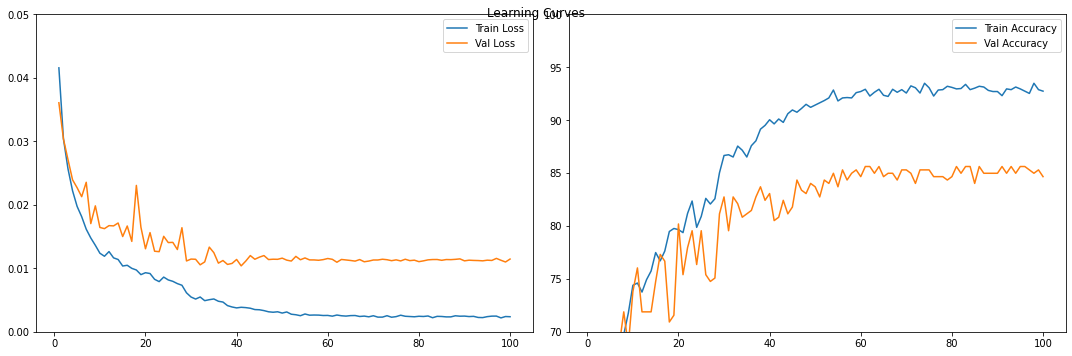

--------------------Best Model-------------------
Best Val Epoch:      96
Best Train Loss:     0.0025
Best Train Accuracy: 92.7454
Best Val Loss:       0.0112
Best Val Accuracy:   85.6230
---------------------------------5번째 oof 종료-------------------------------
---------------------------------6번째 oof 시작-------------------------------
Train Epoch: 1 [0/2813 (0%)]	Train Loss: 4.180587

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0399, 	Train Accuracy: 48.24 %, 	Val Loss: 0.0326, 	Val Accuracy: 52.24 % 

Train Epoch: 2 [0/2813 (0%)]	Train Loss: 1.963691

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0297, 	Train Accuracy: 51.83 %, 	Val Loss: 0.0301, 	Val Accuracy: 53.53 % 

Train Epoch: 3 [0/2813 (0%)]	Train Loss: 1.895128

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0255, 	Train Accuracy: 54.18 %, 	Val Loss: 0.0250, 	Val Accuracy: 54.81 % 

Train Epoch: 4 [0/2813 (0%)]	Train Loss: 1.565129

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0227, 	Train Accuracy: 57.77 %, 	Val Loss: 0.0225, 	Val Accuracy: 60.90 % 

Train Epoc

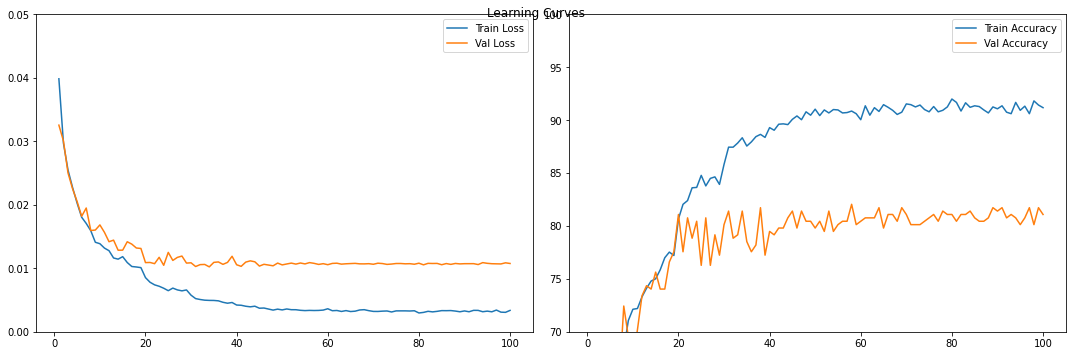

--------------------Best Model-------------------
Best Val Epoch:      58
Best Train Loss:     0.0034
Best Train Accuracy: 90.8638
Best Val Loss:       0.0106
Best Val Accuracy:   82.0513
---------------------------------6번째 oof 종료-------------------------------
---------------------------------7번째 oof 시작-------------------------------
Train Epoch: 1 [0/2813 (0%)]	Train Loss: 4.158150

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0414, 	Train Accuracy: 48.38 %, 	Val Loss: 0.0359, 	Val Accuracy: 51.92 % 

Train Epoch: 2 [0/2813 (0%)]	Train Loss: 1.895609

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0312, 	Train Accuracy: 51.58 %, 	Val Loss: 0.0337, 	Val Accuracy: 52.88 % 

Train Epoch: 3 [0/2813 (0%)]	Train Loss: 2.214234

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0273, 	Train Accuracy: 54.60 %, 	Val Loss: 0.0296, 	Val Accuracy: 55.77 % 

Train Epoch: 4 [0/2813 (0%)]	Train Loss: 1.200143

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0236, 	Train Accuracy: 57.31 %, 	Val Loss: 0.0255, 	Val Accuracy: 60.26 % 

Train Epoc

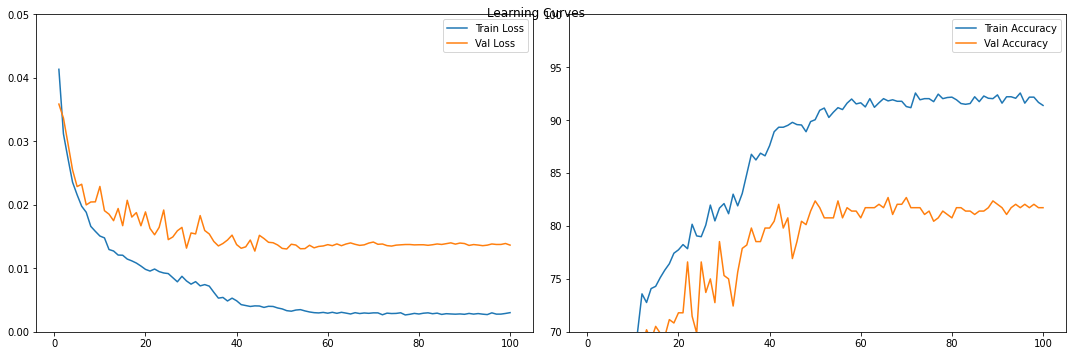

--------------------Best Model-------------------
Best Val Epoch:      70
Best Train Loss:     0.0030
Best Train Accuracy: 91.2904
Best Val Loss:       0.0141
Best Val Accuracy:   82.6923
---------------------------------7번째 oof 종료-------------------------------
---------------------------------8번째 oof 시작-------------------------------
Train Epoch: 1 [0/2813 (0%)]	Train Loss: 4.093074

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0437, 	Train Accuracy: 46.64 %, 	Val Loss: 0.0380, 	Val Accuracy: 49.04 % 

Train Epoch: 2 [0/2813 (0%)]	Train Loss: 1.960836

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0341, 	Train Accuracy: 48.74 %, 	Val Loss: 0.0323, 	Val Accuracy: 52.24 % 

Train Epoch: 3 [0/2813 (0%)]	Train Loss: 2.503415

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0296, 	Train Accuracy: 51.19 %, 	Val Loss: 0.0284, 	Val Accuracy: 57.05 % 

Train Epoch: 4 [0/2813 (0%)]	Train Loss: 1.806704

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0262, 	Train Accuracy: 54.00 %, 	Val Loss: 0.0259, 	Val Accuracy: 58.97 % 

Train Epoc

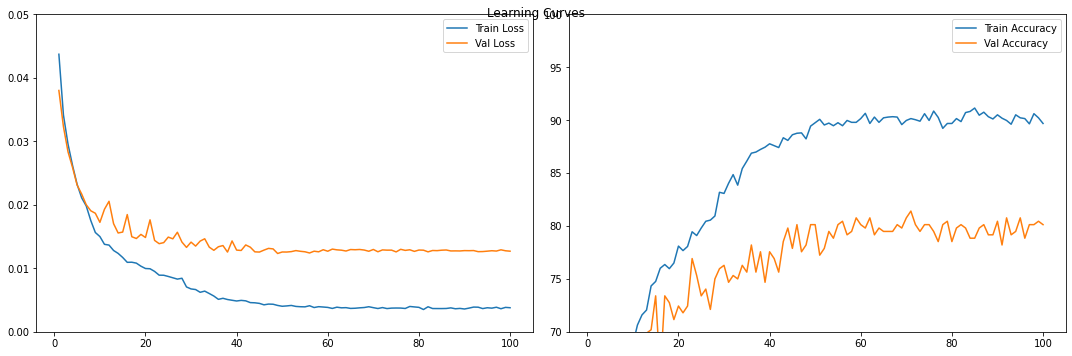

--------------------Best Model-------------------
Best Val Epoch:      71
Best Train Loss:     0.0037
Best Train Accuracy: 90.1529
Best Val Loss:       0.0126
Best Val Accuracy:   81.4103
---------------------------------8번째 oof 종료-------------------------------
---------------------------------9번째 oof 시작-------------------------------
Train Epoch: 1 [0/2813 (0%)]	Train Loss: 4.181852

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0406, 	Train Accuracy: 48.13 %, 	Val Loss: 0.0384, 	Val Accuracy: 49.36 % 

Train Epoch: 2 [0/2813 (0%)]	Train Loss: 1.871746

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0301, 	Train Accuracy: 51.44 %, 	Val Loss: 0.0306, 	Val Accuracy: 55.45 % 

Train Epoch: 3 [0/2813 (0%)]	Train Loss: 2.054404

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0273, 	Train Accuracy: 53.75 %, 	Val Loss: 0.0301, 	Val Accuracy: 55.77 % 

Train Epoch: 4 [0/2813 (0%)]	Train Loss: 1.676792

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0254, 	Train Accuracy: 55.85 %, 	Val Loss: 0.0278, 	Val Accuracy: 57.05 % 

Train Epoc

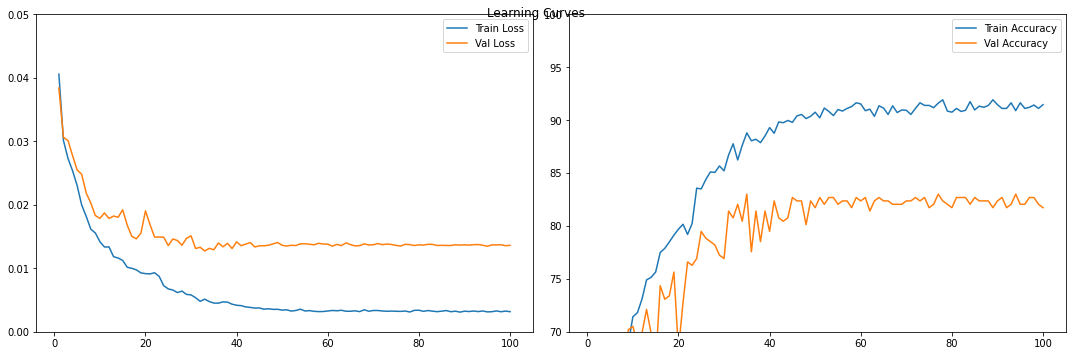

--------------------Best Model-------------------
Best Val Epoch:      94
Best Train Loss:     0.0033
Best Train Accuracy: 90.8994
Best Val Loss:       0.0136
Best Val Accuracy:   83.0128
---------------------------------9번째 oof 종료-------------------------------
---------------------------------10번째 oof 시작-------------------------------
Train Epoch: 1 [0/2813 (0%)]	Train Loss: 3.991888

[EPOCH: 1], Lr: {0.1}	Train Loss: 0.0411, 	Train Accuracy: 47.60 %, 	Val Loss: 0.0371, 	Val Accuracy: 49.36 % 

Train Epoch: 2 [0/2813 (0%)]	Train Loss: 2.140110

[EPOCH: 2], Lr: {0.1}	Train Loss: 0.0302, 	Train Accuracy: 51.01 %, 	Val Loss: 0.0313, 	Val Accuracy: 54.81 % 

Train Epoch: 3 [0/2813 (0%)]	Train Loss: 1.828063

[EPOCH: 3], Lr: {0.1}	Train Loss: 0.0259, 	Train Accuracy: 53.68 %, 	Val Loss: 0.0269, 	Val Accuracy: 56.73 % 

Train Epoch: 4 [0/2813 (0%)]	Train Loss: 1.388879

[EPOCH: 4], Lr: {0.1}	Train Loss: 0.0242, 	Train Accuracy: 56.59 %, 	Val Loss: 0.0306, 	Val Accuracy: 55.45 % 

Train Epo

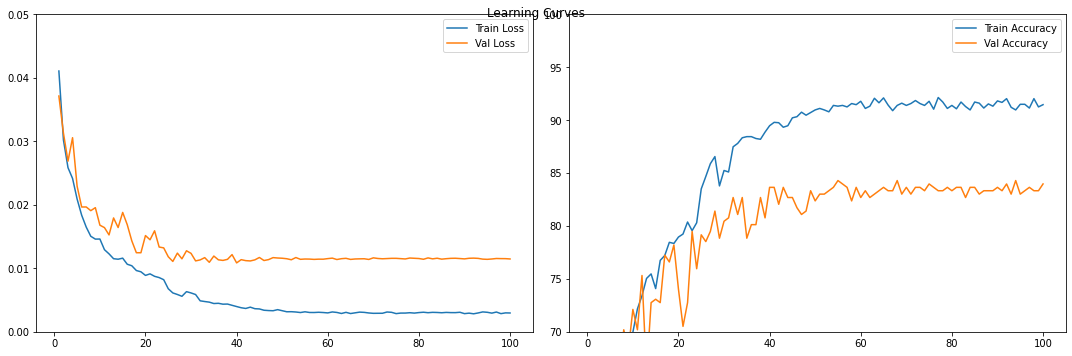

--------------------Best Model-------------------
Best Val Epoch:      94
Best Train Loss:     0.0031
Best Train Accuracy: 90.9705
Best Val Loss:       0.0114
Best Val Accuracy:   84.2949
---------------------------------10번째 oof 종료-------------------------------



In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

# CV는 10으로
n_split = 10

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

train_oof = np.zeros_like(y)
test_oof = np.zeros((test_X.shape[0], num_classes))

test_dataset = CustomDataset(test_X)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)

cnt = 1

for trn_idx, val_idx in tqdm_notebook(skf.split(X, y)):
  trn_data, trn_label = X[trn_idx], y[trn_idx]
  val_data, val_label = X[val_idx], y[val_idx]

  train_dataset = CustomDataset(trn_data, trn_label)
  val_dataset = CustomDataset(val_data, val_label)
  test_dataset = CustomDataset(test)

  train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True)
  
  val_dataloader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)
  
  print(f'---------------------------------{cnt}번째 oof 시작-------------------------------')

  model = CNN(num_classes = num_classes).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, eps = 1e-06, patience = 4)
  criterion = nn.CrossEntropyLoss()

  best_val_accuracy = 0
  result_list = []

  for epoch in range(1, EPOCHS + 1):
    current_lrs = [x["lr"] for x in optimizer.param_groups]

    train_loss, train_accuracy = train(model, train_dataloader, optimizer, log_interval = 50)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print(f"\n[EPOCH: {epoch}], Lr: {set(current_lrs)}\tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {test_loss:.4f}, \tVal Accuracy: {test_accuracy:.2f} % \n")
    scheduler.step(test_loss)

    if best_val_accuracy <= test_accuracy:

      best_info = {
      'epoch': epoch,
      'model': deepcopy(model.state_dict()),
      'train_loss': train_loss,
      'train_metric': train_accuracy,
      'val_loss': test_loss,
      'val_metric': test_accuracy,
      }

      best_val_accuracy = test_accuracy
    
    result = {
        'epoch': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': test_loss,
        'Val Accuracy': test_accuracy
    }
    result_list.append(result)

  result_df = pd.DataFrame(result_list)

  # learning curve 그리기
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  fig.suptitle('Learning Curves')
  axes[0].plot(result_df['epoch'], result_df['Train Loss'], label='Train Loss')
  axes[0].plot(result_df['epoch'], result_df['Val Loss'], label='Val Loss')
  axes[0].set_ylim(0.0, 0.05)
  axes[0].legend()

  axes[1].plot(result_df['epoch'], result_df['Train Accuracy'], label='Train Accuracy')
  axes[1].plot(result_df['epoch'], result_df['Val Accuracy'], label='Val Accuracy')
  axes[1].set_ylim(70, 100)
  axes[1].legend()
  plt.tight_layout()
  plt.show()

  print("--------------------Best Model-------------------")
  print(f"Best Val Epoch:      {best_info['epoch']}")
  print(f"Best Train Loss:     {best_info['train_loss']:.4f}")
  print(f"Best Train Accuracy: {best_info['train_metric']:.4f}")
  print(f"Best Val Loss:       {best_info['val_loss']:.4f}")
  print(f"Best Val Accuracy:   {best_info['val_metric']:.4f}")

  model.load_state_dict(best_info['model'])

  model.eval()
  test_preds = []
  val_preds = []

  with torch.no_grad():

    for inputs in test_dataloader:
      test_preds.append(F.softmax(model(inputs.cuda())).cpu().numpy())

    for inputs, targets in val_dataloader:
      val_preds.append(model(inputs.cuda()).cpu().numpy().argmax(axis=1))

  train_oof[val_idx] = np.concatenate(val_preds)
  test_oof += np.concatenate(test_preds) / n_split

  print(f'---------------------------------{cnt}번째 oof 종료-------------------------------')
  cnt += 1

In [ ]:
from sklearn.metrics import accuracy_score

print('Train accuracy_score: ', accuracy_score(train_oof, y))

Train accuracy_score:  0.83584


In [ ]:
submission.iloc[:,1:] = test_oof
submission.to_csv('CNN_kford_10.csv',index=False)
submission.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,1.063167e-07,8.997465e-05,4.957344e-11,5.167474e-09,1.773383e-05,1.796001e-09,2.513475e-04,2.402807e-08,2.471101e-14,1.692637e-04,2.108412e-02,2.605979e-01,3.018032e-06,6.956602e-01,1.403745e-03,1.470415e-07,1.027512e-05,4.439098e-07,8.308434e-11,1.137981e-12,2.217130e-09,2.665146e-09,7.357458e-09,1.055699e-03,3.188295e-03,4.715247e-10,2.521544e-07,1.127534e-07,1.272332e-09,1.979664e-05,2.069822e-06,4.566453e-04,0.000003,7.552587e-07,2.231271e-06,1.035285e-12,1.105997e-04,6.885231e-03,5.901545e-06,2.426552e-09,9.291656e-07,3.050695e-09,3.743603e-03,5.334500e-05,2.004981e-06,5.333650e-04,6.374438e-08,8.820403e-06,2.061193e-07,8.087733e-08,2.162214e-09,2.466357e-05,2.947105e-08,1.098519e-08,3.468963e-10,1.931007e-12,6.156843e-08,5.981112e-10,4.611881e-03,1.705465e-07,2.331555e-06
1,3126,1.035539e-04,5.176955e-08,4.047449e-10,2.199338e-06,2.962068e-08,8.796059e-05,8.810887e-13,7.110989e-08,8.131685e-14,4.313030e-10,5.494206e-09,4.351315e-13,1.825471e-22,5.673067e-12,5.468629e-12,1.630872e-04,3.610763e-08,3.071190e-07,2.707431e-08,1.734288e-10,2.898451e-09,1.017495e-05,1.002245e-05,8.522712e-05,7.757519e-10,1.519422e-05,9.847849e-01,6.909213e-07,1.089201e-18,6.689477e-13,2.505134e-10,6.442914e-11,0.000060,5.420689e-07,5.516563e-10,4.006813e-05,4.917724e-06,8.073567e-07,4.202967e-11,1.700301e-25,9.660645e-05,3.202539e-04,2.802573e-08,5.130613e-10,6.685614e-10,3.210137e-12,1.245900e-08,6.535399e-05,5.492052e-05,1.389127e-02,1.943386e-04,1.174714e-13,2.432769e-18,2.760360e-11,5.686671e-10,1.118776e-10,6.294978e-08,5.903211e-06,7.170677e-12,1.040409e-06,2.554091e-07
2,3127,3.417896e-03,1.211369e-02,2.164772e-07,1.244695e-05,4.845463e-06,1.551549e-03,7.676838e-09,3.959935e-04,5.767198e-08,1.370581e-07,1.498131e-06,8.731788e-07,1.099221e-11,1.263096e-05,2.227745e-06,5.636243e-04,8.185807e-05,1.618942e-04,2.088618e-07,1.265888e-05,2.513824e-06,4.847556e-04,9.891493e-10,1.290463e-04,2.655513e-07,1.875013e-04,1.226650e-03,6.637685e-06,5.951607e-05,3.026997e-03,2.205267e-10,1.572560e-06,0.003951,1.191014e-03,6.762111e-05,1.802138e-08,2.473868e-05,3.863873e-06,4.910859e-05,1.975711e-07,1.742757e-04,6.316671e-05,1.876494e-01,1.985680e-01,2.218488e-02,4.951794e-01,7.522101e-04,8.935791e-07,2.464329e-03,2.089484e-03,3.462749e-05,1.536902e-04,3.063608e-09,5.330712e-05,4.076972e-06,7.621793e-10,7.860566e-03,1.084250e-07,4.681747e-08,5.575053e-03,4.844488e-02
3,3128,1.006441e-04,6.082305e-09,2.879554e-10,7.866710e-09,6.220826e-09,4.523595e-07,2.074954e-11,1.507276e-08,7.956672e-05,1.082783e-07,1.696709e-06,1.090533e-10,7.235809e-14,1.662630e-13,3.288261e-08,1.609092e-04,1.801155e-12,1.276464e-07,1.669313e-09,5.606092e-11,1.218672e-11,5.830600e-06,7.817861e-11,1.671864e-06,2.373405e-07,1.613478e-07,9.341698e-01,2.606264e-10,1.087220e-09,9.179417e-11,3.111298e-08,4.699345e-12,0.007565,4.565730e-07,1.780398e-08,2.757744e-06,3.062907e-06,8.719503e-11,3.832383e-07,1.002355e-14,2.865211e-09,3.245165e-09,6.342673e-09,1.978274e-07,1.145385e-08,4.597932e-09,1.636325e-08,4.716402e-07,1.576855e-03,3.611900e-02,4.573767e-04,1.978672e-09,1.844125e-10,2.080111e-12,3.400038e-09,2.606733e-11,1.586580e-11,2.071087e-08,4.575505e-10,3.627715e-09,1.975328e-02
4,3129,7.476994e-03,5.003398e-07,6.103166e-13,3.102987e-08,6.800725e-05,1.136788e-08,4.063354e-16,1.453191e-09,4.097429e-09,7.725198e-09,2.901106e-09,2.501750e-12,2.063594e-18,4.553212e-15,1.309836e-08,4.996875e-04,1.822168e-10,2.778328e-09,9.346313e-06,1.084325e-12,1.358862e-12,1.363967e-09,1.817272e-08,2.952650e-09,5.505175e-06,5.890183e-07,9.871293e-01,3.881034e-14,3.513284e-10,2.684524e-13,5.242676e-12,5.135229e-12,0.001542,3.232489e-08,1.615786e-04,1.795056e-10,5.019591e-09,1.690376e-10,8.975972e-09,2.829954e-14,8.279244e-11,3.815754e-10,1.411623e-07,8.773868e-07,1.043848e-15,2.302418e-15,9.710802e-08,2.693989e-09,1.592186e-03